In [1]:
from typing import Annotated,TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages 

from langchain_ollama import ChatOllama


In [2]:
llm = ChatOllama(model="llama2:7b",base_url="http://localhost:11434")

In [3]:
from langchain_community.tools.tavily_search.tool import TavilySearchResults

In [4]:
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool





In [5]:
@tool
def internet_search(query : str):
    """
    Search the web for real time information.
    Args:
    query: The search query 
    """
    search = TavilySearchResults(
    max_results = 3,
    search_depth = 'advanced',
    include_answer =True,   
    include_raw_content =True,
    )

    response = search.invoke("What is latest stock market news in India?")
    return response

In [6]:
internet_search

StructuredTool(name='internet_search', description='Search the web for real time information.\nArgs:\nquery: The search query', args_schema=<class 'langchain_core.utils.pydantic.internet_search'>, func=<function internet_search at 0x00000236A61A6340>)

In [7]:
@tool 
def llm_search(query:str):
    """
    Use LLM model for basic and general information 
    """
    message = HumanMessage(query)
    response = llm.invoke(message)
    return response


In [8]:
llm_search

StructuredTool(name='llm_search', description='Use LLM model for basic and general information', args_schema=<class 'langchain_core.utils.pydantic.llm_search'>, func=<function llm_search at 0x00000236A61A6660>)

In [9]:
tools = [internet_search,llm_search]
tools

[StructuredTool(name='internet_search', description='Search the web for real time information.\nArgs:\nquery: The search query', args_schema=<class 'langchain_core.utils.pydantic.internet_search'>, func=<function internet_search at 0x00000236A61A6340>),
 StructuredTool(name='llm_search', description='Use LLM model for basic and general information', args_schema=<class 'langchain_core.utils.pydantic.llm_search'>, func=<function llm_search at 0x00000236A61A6660>)]

In [10]:
llm_with_tool = llm.bind_tools(tools)

In [11]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

def chatbot(state:State):
    response = llm_with_tool.invoke(state["messages"])
    return {"messages":[response]}



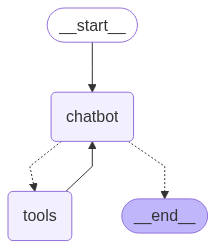

In [12]:
from IPython.display import display,Image


graph_build = StateGraph(State)
graph_build.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_build.add_node("tools",tool_node)

graph_build.add_conditional_edges("chatbot",tools_condition)

graph_build.add_edge("tools","chatbot")

graph_build.set_entry_point("chatbot")

graph = graph_build.compile()

display(Image(graph.get_graph().draw_mermaid_png()))